In [26]:
# !pip install shap
# !pip install lime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

# Increase display precision (optional)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [27]:
SAMPLE_SIZE = 500  # Adjust as needed for faster debugging, or set to None


In [28]:
# Load Adult Income Dataset
adult_cols = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]
adult_path = "data/adult.data"
adult_df = pd.read_csv(adult_path, names=adult_cols, nrows=SAMPLE_SIZE)

# Load Titanic Dataset
titanic_path = "data/Titanic-Dataset.csv"
titanic_df = pd.read_csv(titanic_path, nrows=SAMPLE_SIZE)

# Load Diabetes Prediction Dataset
diabetes_path = "data/diabetes_prediction_dataset.csv"
diabetes_df = pd.read_csv(diabetes_path, nrows=SAMPLE_SIZE)

# Load Loan Default Prediction Dataset
loan_path = "data/Loan_default.csv"
loan_df = pd.read_csv(loan_path, nrows=SAMPLE_SIZE)

print("Adult Income Dataset Shape:", adult_df.shape)
print("Titanic Dataset Shape:", titanic_df.shape)
print("Diabetes Dataset Shape:", diabetes_df.shape)
print("Loan Default Dataset Shape:", loan_df.shape)


Adult Income Dataset Shape: (500, 15)
Titanic Dataset Shape: (500, 12)
Diabetes Dataset Shape: (500, 9)
Loan Default Dataset Shape: (500, 18)


In [29]:
print("===== Adult Dataset (head) =====")
display(adult_df.head())
print(adult_df.info())

print("\n===== Titanic Dataset (head) =====")
display(titanic_df.head())
print(titanic_df.info())

print("\n===== Diabetes Dataset (head) =====")
display(diabetes_df.head())
print(diabetes_df.info())

print("\n===== Loan Dataset (head) =====")
display(loan_df.head())
print(loan_df.info())


===== Adult Dataset (head) =====


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             500 non-null    int64 
 1   workclass       500 non-null    object
 2   fnlwgt          500 non-null    int64 
 3   education       500 non-null    object
 4   education_num   500 non-null    int64 
 5   marital_status  500 non-null    object
 6   occupation      500 non-null    object
 7   relationship    500 non-null    object
 8   race            500 non-null    object
 9   sex             500 non-null    object
 10  capital_gain    500 non-null    int64 
 11  capital_loss    500 non-null    int64 
 12  hours_per_week  500 non-null    int64 
 13  native_country  500 non-null    object
 14  income          500 non-null    object
dtypes: int64(6), object(9)
memory usage: 58.7+ KB
None

===== Titanic Dataset (head) =====


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  500 non-null    int64  
 1   Survived     500 non-null    int64  
 2   Pclass       500 non-null    int64  
 3   Name         500 non-null    object 
 4   Sex          500 non-null    object 
 5   Age          398 non-null    float64
 6   SibSp        500 non-null    int64  
 7   Parch        500 non-null    int64  
 8   Ticket       500 non-null    object 
 9   Fare         500 non-null    float64
 10  Cabin        113 non-null    object 
 11  Embarked     499 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 47.0+ KB
None

===== Diabetes Dataset (head) =====


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.000,0,1,never,25.190,6.600,140,0
1,Female,54.000,0,0,No Info,27.320,6.600,80,0
2,Male,28.000,0,0,never,27.320,5.700,158,0
3,Female,36.000,0,0,current,23.450,5.000,155,0
4,Male,76.000,1,1,current,20.140,4.800,155,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               500 non-null    object 
 1   age                  500 non-null    float64
 2   hypertension         500 non-null    int64  
 3   heart_disease        500 non-null    int64  
 4   smoking_history      500 non-null    object 
 5   bmi                  500 non-null    float64
 6   HbA1c_level          500 non-null    float64
 7   blood_glucose_level  500 non-null    int64  
 8   diabetes             500 non-null    int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 35.3+ KB
None

===== Loan Dataset (head) =====


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.230,36,0.440,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.810,60,0.680,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.170,24,0.310,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.070,24,0.230,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.510,48,0.730,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LoanID          500 non-null    object 
 1   Age             500 non-null    int64  
 2   Income          500 non-null    int64  
 3   LoanAmount      500 non-null    int64  
 4   CreditScore     500 non-null    int64  
 5   MonthsEmployed  500 non-null    int64  
 6   NumCreditLines  500 non-null    int64  
 7   InterestRate    500 non-null    float64
 8   LoanTerm        500 non-null    int64  
 9   DTIRatio        500 non-null    float64
 10  Education       500 non-null    object 
 11  EmploymentType  500 non-null    object 
 12  MaritalStatus   500 non-null    object 
 13  HasMortgage     500 non-null    object 
 14  HasDependents   500 non-null    object 
 15  LoanPurpose     500 non-null    object 
 16  HasCoSigner     500 non-null    object 
 17  Default         500 non-null    int

In [30]:
def basic_eda_plots(df, dataset_name, max_unique_cat=10):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        fig, ax = plt.subplots()
        ax.hist(df[col].dropna())
        ax.set_title(f"{dataset_name} - Histogram of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
        plt.show()

    cat_cols = df.select_dtypes(exclude=[np.number]).columns
    for col in cat_cols:
        if df[col].nunique() <= max_unique_cat:
            fig, ax = plt.subplots()
            df[col].value_counts().plot(kind='bar', ax=ax)
            ax.set_title(f"{dataset_name} - Count of {col}")
            ax.set_xlabel(col)
            ax.set_ylabel("Count")
            plt.show()


# basic_eda_plots(adult_df, "Adult")
# basic_eda_plots(titanic_df, "Titanic")
# basic_eda_plots(diabetes_df, "Diabetes")
# basic_eda_plots(loan_df, "Loan")


In [31]:
def preprocess_adult_data(df):
    df.replace("?", np.nan, inplace=True)
    df.dropna(inplace=True)

    df['income'] = df['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)


    cat_cols = df.select_dtypes(exclude=[np.number]).columns
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

    return df

def preprocess_titanic_data(df):
    df.dropna(subset=["Age", "Embarked", "Sex"], inplace=True)

    df['Sex'] = df['Sex'].map({'male': 1, 'female': 0}).astype(int)

    df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])

    df = df.drop(['Name', 'Ticket', 'Cabin'], axis=1)

    return df

def preprocess_diabetes_data(df):
    df.dropna(inplace=True)
    df['diabetes'] = df['diabetes'].apply(lambda x: 1 if x==1 else 0)

    # Label encode the "gender", "smoking_history" if they're categorical
    cat_cols = df.select_dtypes(exclude=[np.number]).columns
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

    return df

def preprocess_loan_data(df):
    df.dropna(inplace=True)
    cat_cols = df.select_dtypes(exclude=[np.number]).columns
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

    return df

# Apply preprocessing
adult_df = preprocess_adult_data(adult_df)
titanic_df = preprocess_titanic_data(titanic_df)
diabetes_df = preprocess_diabetes_data(diabetes_df)
loan_df = preprocess_loan_data(loan_df)

print("Adult preprocessed shape:", adult_df.shape)
print("Titanic preprocessed shape:", titanic_df.shape)
print("Diabetes preprocessed shape:", diabetes_df.shape)
print("Loan preprocessed shape:", loan_df.shape)


Adult preprocessed shape: (500, 15)
Titanic preprocessed shape: (397, 9)
Diabetes preprocessed shape: (500, 9)
Loan preprocessed shape: (500, 18)


In [32]:
X_adult = adult_df.drop("income", axis=1)
y_adult = adult_df["income"]

X_titanic = titanic_df.drop("Survived", axis=1)
y_titanic = titanic_df["Survived"]

X_diabetes = diabetes_df.drop("diabetes", axis=1)
y_diabetes = diabetes_df["diabetes"]

X_loan = loan_df.drop("Default", axis=1)
y_loan = loan_df["Default"]


In [33]:
def train_evaluate_random_forest(X, y, dataset_name):
    # Simple train/test split for demonstration
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='binary')
    print(f"{dataset_name} - Accuracy: {acc:.4f}, F1: {f1:.4f}")
    return model, acc, f1

print("===== Baseline (All Features) =====")
_, adult_acc_all, adult_f1_all = train_evaluate_random_forest(X_adult, y_adult, "Adult")
_, titanic_acc_all, titanic_f1_all = train_evaluate_random_forest(X_titanic, y_titanic, "Titanic")
_, diabetes_acc_all, diabetes_f1_all = train_evaluate_random_forest(X_diabetes, y_diabetes, "Diabetes")
_, loan_acc_all, loan_f1_all = train_evaluate_random_forest(X_loan, y_loan, "Loan")


===== Baseline (All Features) =====
Adult - Accuracy: 0.8600, F1: 0.6500
Titanic - Accuracy: 0.8250, F1: 0.7200
Diabetes - Accuracy: 0.9800, F1: 0.8000
Loan - Accuracy: 0.8700, F1: 0.0000


In [34]:
def correlation_based_feature_selection(X, y, threshold=0.1):
    # Temporarily add target to compute correlation
    temp_df = X.copy()
    temp_df['target'] = y
    corr_matrix = temp_df.corr().abs()

    # Correlation of each feature with target
    target_corr = corr_matrix['target'].drop('target')

    # Filter features
    selected_features = target_corr[target_corr >= threshold].index
    return list(selected_features)

def apply_feature_selection_and_evaluate(X, y, dataset_name, selection_func, **kwargs):
    selected_feats = selection_func(X, y, **kwargs)
    print(f"{dataset_name} - Selected features: {selected_feats}")

    X_sel = X[selected_feats]
    model, acc, f1 = train_evaluate_random_forest(X_sel, y, dataset_name + " (FS)")
    return selected_feats, acc, f1

print("===== Correlation-based Feature Selection =====")
adult_feats_corr, adult_acc_corr, adult_f1_corr = apply_feature_selection_and_evaluate(
    X_adult, y_adult, "Adult", correlation_based_feature_selection, threshold=0.1
)
titanic_feats_corr, titanic_acc_corr, titanic_f1_corr = apply_feature_selection_and_evaluate(
    X_titanic, y_titanic, "Titanic", correlation_based_feature_selection, threshold=0.1
)
diabetes_feats_corr, diabetes_acc_corr, diabetes_f1_corr = apply_feature_selection_and_evaluate(
    X_diabetes, y_diabetes, "Diabetes", correlation_based_feature_selection, threshold=0.1
)
loan_feats_corr, loan_acc_corr, loan_f1_corr = apply_feature_selection_and_evaluate(
    X_loan, y_loan, "Loan", correlation_based_feature_selection, threshold=0.1
)


===== Correlation-based Feature Selection =====
Adult - Selected features: ['age', 'education_num', 'marital_status', 'relationship', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week']
Adult (FS) - Accuracy: 0.8100, F1: 0.5581
Titanic - Selected features: ['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked']
Titanic (FS) - Accuracy: 0.7750, F1: 0.6667
Diabetes - Selected features: ['age', 'hypertension', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']
Diabetes (FS) - Accuracy: 0.9800, F1: 0.8000
Loan - Selected features: ['Age', 'HasDependents']
Loan (FS) - Accuracy: 0.8300, F1: 0.1053


In [35]:
def shap_feature_selection(X, y, top_k=4):
    # Train a quick random forest
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)

    # SHAP Explanation
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)


    shap_abs_mean = np.mean(np.abs(shap_values), axis=0).mean(axis=0)

    # Pair up with feature names
    feature_importances = list(zip(X.columns, shap_abs_mean))
    # Sort by importance descending
    feature_importances.sort(key=lambda x: x[1], reverse=True)

    selected_feats = [f[0] for f in feature_importances[:top_k]]
    return selected_feats, feature_importances

def apply_shap_feature_selection(X, y, dataset_name, top_k=5):
    selected_feats, feat_imps = shap_feature_selection(X, y, top_k=top_k)
    print(f"{dataset_name} - Top {top_k} features by SHAP: {selected_feats}")

    # Evaluate model performance on these top k features
    X_sel = X[selected_feats]
    model, acc, f1 = train_evaluate_random_forest(X_sel, y, dataset_name + f"(SHAP top {top_k})")

    print(f"{dataset_name} - SHAP Feature Importances (desc order):")
    for f, imp in feat_imps:
        print(f"{f}: {imp:.4f}")

    return selected_feats, acc, f1

print("===== SHAP-based Feature Selection =====")
adult_feats_shap, adult_acc_shap, adult_f1_shap = apply_shap_feature_selection(X_adult, y_adult, "Adult", top_k=4)
titanic_feats_shap, titanic_acc_shap, titanic_f1_shap = apply_shap_feature_selection(X_titanic, y_titanic, "Titanic", top_k=4)
diabetes_feats_shap, diabetes_acc_shap, diabetes_f1_shap = apply_shap_feature_selection(X_diabetes, y_diabetes, "Diabetes", top_k=4)
loan_feats_shap, loan_acc_shap, loan_f1_shap = apply_shap_feature_selection(X_loan, y_loan, "Loan", top_k=4)


===== SHAP-based Feature Selection =====
Adult - Top 4 features by SHAP: ['age', 'workclass']
Adult(SHAP top 4) - Accuracy: 0.6900, F1: 0.2051
Adult - SHAP Feature Importances (desc order):
age: 0.0287
workclass: 0.0287
Titanic - Top 4 features by SHAP: ['Pclass', 'PassengerId']
Titanic(SHAP top 4) - Accuracy: 0.5875, F1: 0.3774
Titanic - SHAP Feature Importances (desc order):
Pclass: 0.0606
PassengerId: 0.0606
Diabetes - Top 4 features by SHAP: ['gender', 'age']
Diabetes(SHAP top 4) - Accuracy: 0.9100, F1: 0.0000
Diabetes - SHAP Feature Importances (desc order):
gender: 0.0210
age: 0.0210
Loan - Top 4 features by SHAP: ['LoanID', 'Age']
Loan(SHAP top 4) - Accuracy: 0.8600, F1: 0.0000
Loan - SHAP Feature Importances (desc order):
LoanID: 0.0123
Age: 0.0123


In [36]:
comparison_df = pd.DataFrame({
    "Dataset": ["Adult", "Titanic", "Diabetes", "Loan"],
    "All_Features_Accuracy": [adult_acc_all, titanic_acc_all, diabetes_acc_all, loan_acc_all],
    "All_Features_F1": [adult_f1_all, titanic_f1_all, diabetes_f1_all, loan_f1_all],
    "Corr_FS_Accuracy": [adult_acc_corr, titanic_acc_corr, diabetes_acc_corr, loan_acc_corr],
    "Corr_FS_F1": [adult_f1_corr, titanic_f1_corr, diabetes_f1_corr, loan_f1_corr],
    "SHAP_FS_Accuracy": [adult_acc_shap, titanic_acc_shap, diabetes_acc_shap, loan_acc_shap],
    "SHAP_FS_F1": [adult_f1_shap, titanic_f1_shap, diabetes_f1_shap, loan_f1_shap]
})

print("===== Model Comparison Table =====")
display(comparison_df)


===== Model Comparison Table =====


,Dataset,All_Features_Accuracy,All_Features_F1,Corr_FS_Accuracy,Corr_FS_F1,SHAP_FS_Accuracy,SHAP_FS_F1
0,Adult,0.860,0.650,0.810,0.558,0.690,0.205
1,Titanic,0.825,0.720,0.775,0.667,0.588,0.377
2,Diabetes,0.980,0.800,0.980,0.800,0.910,0.000
3,Loan,0.870,0.000,0.830,0.105,0.860,0.000


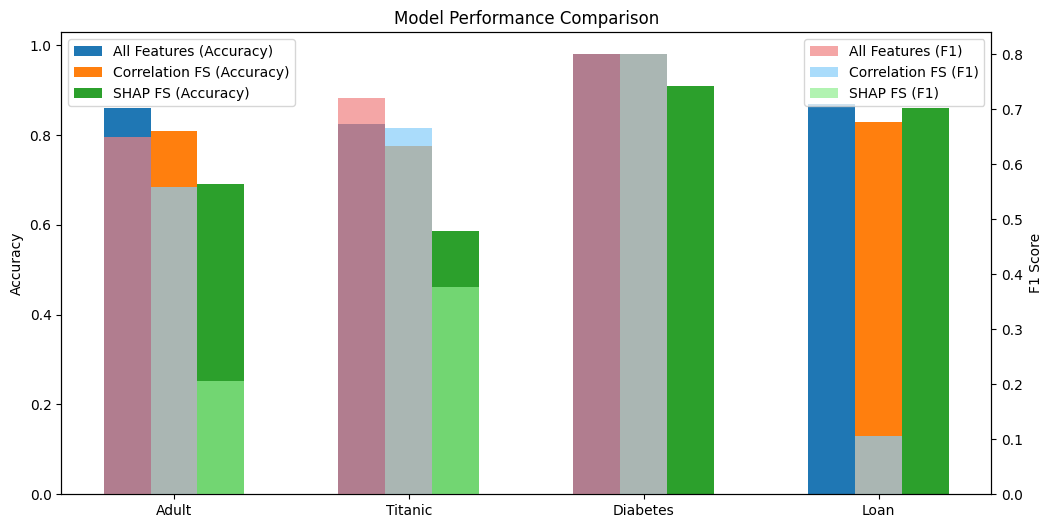

In [37]:
import matplotlib.pyplot as plt
import numpy as np

datasets = comparison_df["Dataset"].values
all_features_acc = comparison_df["All_Features_Accuracy"].values
all_features_f1 = comparison_df["All_Features_F1"].values
corr_fs_acc = comparison_df["Corr_FS_Accuracy"].values
corr_fs_f1 = comparison_df["Corr_FS_F1"].values
shap_fs_acc = comparison_df["SHAP_FS_Accuracy"].values
shap_fs_f1 = comparison_df["SHAP_FS_F1"].values

# Set up the bar positions
x = np.arange(len(datasets))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for Accuracy
rects1 = ax.bar(x - width, all_features_acc, width, label='All Features (Accuracy)')
rects2 = ax.bar(x, corr_fs_acc, width, label='Correlation FS (Accuracy)')
rects3 = ax.bar(x + width, shap_fs_acc, width, label='SHAP FS (Accuracy)')

# Create bars for F1 Score (on a secondary y-axis)
ax2 = ax.twinx()
rects4 = ax2.bar(x - width, all_features_f1, width, label='All Features (F1)', color='lightcoral', alpha=0.7)
rects5 = ax2.bar(x, corr_fs_f1, width, label='Correlation FS (F1)', color='lightskyblue', alpha=0.7)
rects6 = ax2.bar(x + width, shap_fs_f1, width, label='SHAP FS (F1)', color='lightgreen', alpha=0.7)

# Add labels, title, and legend
ax.set_ylabel('Accuracy')
ax2.set_ylabel('F1 Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()